In [11]:

# Importation des librairies
import pandas as pd                                                         # Pour la manipulation des données
import numpy as np                                                          # Pour les calculs
import seaborn as sns                                                       # Pour les graphiques
import matplotlib.pyplot as plt                                      
from sklearn.model_selection import train_test_split                        # Pour séparer le jeu de données en jeu d'entraînement et jeu de test
from sklearn.ensemble import RandomForestClassifier                         # Pour le modèle de classification
from sklearn.preprocessing import StandardScaler                            # Pour la standardisation des données
from sklearn.model_selection import GridSearchCV, cross_validate            # Pour la validation croisée
from sklearn.model_selection import cross_val_score, StratifiedKFold        # Pour la validation croisée
from sklearn.model_selection import RandomizedSearchCV, RandomizedSearchCV  # Pour la validation croisée
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve           # Pour le scoring
from sklearn.metrics import classification_report, confusion_matrix         
from sklearn.metrics import precision_score, recall_score, f1_score         
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.metrics import recall_score,fbeta_score                        # Pour le score Fbeta                   
from tqdm.notebook import tqdm                                              # Pour la barre de chargement
from time import time                                                       # Pour calculer le temps d'exécution
from itertools import product                                               # Pour faire des boucles sur plusieurs paramètres   
from imblearn.under_sampling import RandomUnderSampler                      # Pour le sous-échantillonnage
from imblearn.over_sampling import RandomOverSampler                        # Pour le sur-échantillonnage
import pickle                                                               # Pour sauvegarder le modèle
from sklearn.model_selection import cross_val_predict                       # Pour la validation croisée
import ast                                                                  # Pour convertir une chaîne de caractères en liste
from sklearn.metrics import precision_recall_curve, auc                     # Pour la courbe de précision-rappel


pd.options.display.max_columns = 60
pd.options.display.max_rows = 150
pd.set_option('display.max_colwidth', None)


1. [**Import Dataset verification de la repartition des classes**](#1.-Import-Dataset-verification-de-la-repartition-des-classes)
2. [**Separation du dataset en test/train**](#2.-Separation-du-dataset-en-test/train)
3. [**Fonctions generales**](#3.-Fonctions-generales)
4. [**Test de différentes méthodes d'échantillonnage**](#4.-Test-de-differentes-methodes-dechantillonnage)
    1.  [Fonctions](#4.1-Fonctions)
    2.  [Sauvegarde/Import des resultats](#4.2-Sauvegarde/Import-des-resultats)
    3.  [Resultats](#4.3-Resultats)
5. [**Recherche d'Hyperparametres avec RandomGridSearchCV**](#5.-Recherche-d'Hyperparametres-avec-RandomGridSearchCV) 
    1.  [Sauvegarde/recharge des resultats du gridsearchCV](#5.1-Sauvegarde/recharge-des-resultats-du-model)
    2.  [Affichage et analyse de resultats](#5.2-Affichage-de-resultats)
6. [**Resultats du model sur le donnees de test**](#6.-Resultats-du-model-sur-le-donnees-de-test)
    1.  [Entraînement du modèle](#6.1-Entrainement-du-modele)  
    2.  [Sauvegarde/Recharge du modele](#6.2-Sauvegarde/Recharge-du-modele)   
    3.  [Prédiction sur le dataset de test](#6.3-Prediction-sur-le-dataset-de-train/test)
7. [**Feature Importance with Random Forests**](#7.-Feature-Importance-with-Random-Forests)
8. [**Optimisation des resultat de prediction**](#8.-Optimisation-des-resultat-de-prediction)
    1.  [ROC/AUC](#8.1-ROC/AUC)
    2.  [Courbe Fscore](#8.2-Courbe-Fscore)
        - a. [Affichage des courbes](#8.2.1.-Affichage-des-courbes)
        - b. [Optimisation du score](#8.2.2.-Optimisation-du-score)


### **1. Import Dataset verification de la repartition des classes**

In [12]:
# Import dataset
df = pd.read_csv('1_Project_RoadAccident/data/dataset_18-21_for_model_encoding.csv',sep=',', index_col=0)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/dataset_18-21_for_model_encoding.csv'

> 1 – Indemne , 4 – Blessé léger   - categorie 0  :  Pas gave
> 
> 2 – Tué , 3 – Blessé hospitalisé - categorie 1  :  Grave

In [ ]:
# Distribution des classes
df_c = df.copy()
df_c['grav'] = df_c['grav'].replace([1.0, 4.0],0).replace([2.0, 3.0],1)
print(round(df_c['grav'].value_counts(normalize= True)*100,1).map(lambda x: f"{x}%"))

print('\n')

Repartition = pd.crosstab(df_c['grav'], df_c['grav'], normalize='all').round(3)*100
Repartition = Repartition.rename(index={0: 'Pas grave', 1: 'Graves'}, columns={0: 'Pas Grave', 1: 'Graves'}). \
                                                rename_axis('', axis='rows').rename_axis('', axis='columns')

print("\033[1mRepartition de la variable cible par default en [%]\033[0m\n")
print(Repartition)

0.0    81.7%
1.0    18.3%
Name: grav, dtype: object


Repartition de la variable cible par default en [%]

           Pas Grave  Graves
                            
Pas grave       81.7     0.0
Graves           0.0    18.3


### **2. Separation du dataset en test/train**

In [ ]:
X = df_c.drop('grav', axis=1)  
y = df_c['grav']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Verification de la repar

df_train = y_train.value_counts(normalize=True) * 100
print("Répartition des classes dans l'ensemble d'entraînement:")
print(round(df_train, 1))

df_test =y_test.value_counts(normalize=True) * 100
print("\nRépartition des classes dans l'ensemble de test:")
print(round(df_test, 1))

Répartition des classes dans l'ensemble d'entraînement:
0.0    81.7
1.0    18.3
Name: grav, dtype: float64

Répartition des classes dans l'ensemble de test:
0.0    81.6
1.0    18.4
Name: grav, dtype: float64


### **3. Fonctions generales**

In [ ]:
# Model simple Random Forest binaire
def RF_bin_simple(X_train, X_test, y_train, y_test, param_grid):
    mod_RF_simple = RandomForestClassifier(**param_grid, n_jobs=-1, random_state=42)
    mod_RF_simple.fit(X_train, y_train)
    return mod_RF_simple
# Print les paramètres du modèle
def parameters(model):
    params = model.get_params()
    df_params = pd.DataFrame.from_dict(params, orient='index', columns=['Valeur'])  # Créer un DataFrame à partir du dictionnaire de paramètres
    return print(df_params)
# Print les rapports de classification
def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
def print_rapports(y_train, y_train_pred, y_test, y_test_pred):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    # Matrice de confusion pour les données d'entraînement
    axes[0].set_title("Matrice de confusion - Données de train")
    plot_confusion_matrix(y_train, y_train_pred, title='Confusion Matrix - Train Data', ax=axes[0])

    # Matrice de confusion pour les données de test
    axes[1].set_title("Matrice de confusion - Données de test")
    plot_confusion_matrix(y_test, y_test_pred, title='Confusion Matrix - Test Data', ax=axes[1])

    plt.tight_layout()
    plt.show()

    # Rapport de classification pour les données d'entraînement
    print("Rapport de classification - Données d'entraînement :")
    print(classification_report(y_train, y_train_pred))
    print("\n"*2)

    # Rapport de classification pour les données de test
    print("Rapport de classification - Données de test :")
    print(classification_report(y_test, y_test_pred))
# Print les courbes ROC  
def plot_roc_curve(model, X_test, y_test):
    ns_probs = [0 for _ in range(len(y_test))]
    y_prob = model.predict_proba(X_test)[:, 1]

    ns_auc = roc_auc_score(y_test, ns_probs)
    RF_roc = roc_auc_score(y_test, y_prob)

    # Calcul de la courbe ROC
    rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_prob)
    ns_fpr, ns_tpr, ns_thresholds = roc_curve(y_test, ns_probs)

    # Affichage de la courbe ROC
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Courbe ROC')

    # Trouver le point le plus proche du coin supérieur gauche
    closest_idx = np.argmin(np.sqrt((rf_fpr - 0)**2 + (rf_tpr - 1)**2))
    closest_point = (rf_fpr[closest_idx], rf_tpr[closest_idx])
    closest_threshold = rf_thresholds[closest_idx]

    # Récupérer les valeurs de probabilité pour le point le plus proche du coin 
    closest_prob = y_prob[np.argmax(np.logical_and(rf_fpr == closest_point[0], rf_tpr == closest_point[1]))]

    # Appliquer le seuil de probabilité aux prédictions 
    closest_pred = (y_prob >= closest_threshold).astype(int)

    # Calculer les métriques de performance
    closest_precision = precision_score(y_test, closest_pred)
    closest_recall = recall_score(y_test, closest_pred)
    closest_f1 = f1_score(y_test, closest_pred)

    # Tracer la courbe ROC
    plt.scatter(closest_point[0], closest_point[1], color='red', label='Point le plus proche', s=100, marker='o')

    # Afficher les résultats pour le point le plus proche du coin supérieur gauche
    print("Résultats pour le point le plus proche du coin :")
    print('Coordonnées du point le plus proche : ({:.2f}, {:.2f})'.format(closest_point[0], closest_point[1]))
    print("Seuil de probabilité : {:.4f}".format(closest_threshold))
    print("Precision: {:.2f}".format(closest_precision))
    print("Recall: {:.2f}".format(closest_recall))
    print("F1-Score: {:.2f}".format(closest_f1))
    print("AUC-ROC : {:.2f}".format(RF_roc))

    # Afficher le graphique
    plt.legend()
    plt.show() 
# Optimisation le recall
def evaluate_model_with_threshold(model, X_test, y_test, recall_threshold):
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculer la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_roc = roc_auc_score(y_test, y_prob)

    
    thresholds_dense = np.linspace(0, 1, 100)

    # Rechercher le seuil de probabilité qui maximise le rappel tout en maintenant une précision acceptable
    best_threshold = None
    best_precision = 0.0
    best_recall = 0.0
    for threshold in thresholds_dense:
        y_pred = (y_prob >= threshold).astype(int)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        if recall >= recall_threshold:
            if precision > best_precision or (precision == best_precision and recall > best_recall):
                best_threshold = threshold
                best_precision = precision
                best_recall = recall

    # Appliquer le meilleur seuil de probabilité aux prédictions
    y_pred_best = (y_prob >= best_threshold).astype(int)

    # Calculer les métriques de performance avec le meilleur seuil
    precision = precision_score(y_test, y_pred_best)
    recall = recall_score(y_test, y_pred_best)
    f1 = f1_score(y_test, y_pred_best)

    # Afficher les résultats
    print("Résultats pour le point qui maximise le rappel :")
    print("Seuil de probabilité : {:.4f}".format(best_threshold))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("AUC-ROC : {:.2f}".format(auc_roc)) 

In [ ]:
#old version recherhce sur unbalanced dataset
'''
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import make_scorer, matthews_corrcoef, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

def compare_methods_inbalamced_ds(X_train, X_test, y_train, y_test):
# Methode 0 : Utilisation de Random Forest sans équilibrer les classes
    # Cross validation
    rf_cv = RandomForestClassifier(random_state=42)
    cv_scoring = {'MCC': make_scorer(matthews_corrcoef), 'f1': make_scorer(f1_score)}
    cv_0 = cross_validate(rf_cv, X_train, y_train, cv=3, scoring=cv_scoring, return_train_score=True)
    score_0 = cv_0['test_MCC', 'test_f1'].mean()
    
# Méthode 1 : Utilisation balanced_subsample pour équilibrer les classes
    rf_balanced_subsample = RandomForestClassifier(class_weight='balanced_subsample', random_state=42)
    cv_scoring = {'MCC': make_scorer(matthews_corrcoef), 'f1': make_scorer(f1_score)}
    cv_1 = cross_validate(rf_cv, X_train, y_train, cv=3, scoring=cv_scoring, return_train_score=True)
    score_1 = cv_1['test_MCC', 'test_f1'].mean()
    
# Méthode 2 : Utilisation de StratifiedKFold pour la validation croisée stratifiée (à comparer au KFold)
    cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    rf_stratified_kfold = RandomForestClassifier(random_state=42)
    #scores_stratified_kfold = cross_val_score(rf_stratified_kfold, X_train, y_train, cv=cv_stratified, scoring=scoring, return_train_score=True)
    y_pred_stratified_kfold = cross_val_predict(rf_stratified_kfold, X_train, y_train, cv=cv_stratified)

# Méthode 3 : Utilisation de l'undersampling pour équilibrer les classes
    rus = RandomUnderSampler(random_state=42)
    X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)
    rf_undersampled = RandomForestClassifier(random_state=42)
    #scores_undersampled = cross_val_score(rf_undersampled, X_train_undersampled, y_train_undersampled, cv=3, scoring=scoring, return_train_score=True)
    y_pred_undersampled = cross_val_predict(rf_undersampled, X_train_undersampled, y_train_undersampled, cv=3)
    return y_pred_balanced_subsample, y_pred_stratified_kfold, y_pred_undersampled, y_train_undersampled
    
def print_results_inbalamced_ds(y_pred_balanced_subsample, y_pred_stratified_kfold, y_pred_undersampled, y_train_undersampled, y_train):
    print("Méthode: balanced_subsample")
    report_balanced_subsample = classification_report(y_train, y_pred_balanced_subsample, output_dict=False)
    print("Rapport de classification avec valeurs moyennes pour tous les plis:")
    print(report_balanced_subsample)
    print("\n")

    print("Méthode: StratifiedKFold")
    report_stratified_kfold = classification_report(y_train, y_pred_stratified_kfold, output_dict=False)
    print("Rapport de classification avec valeurs moyennes pour tous les plis:")
    print(report_stratified_kfold)
    print("\n")

    print("Méthode: RandomUnderSampler")
    report_undersampled = classification_report(y_train_undersampled, y_pred_undersampled, output_dict=False)
    print("Rapport de classification avec valeurs moyennes pour tous les plis:")
    print(report_undersampled)
    print("\n")
    
# Appeler la fonction pour obtenir les prédictions
y_pred_balanced_subsample, y_pred_stratified_kfold, y_pred_undersampled, y_train_undersampled = compare_methods_inbalamced_ds(X_train, X_test, y_train, y_test)

# Afficher les résultats
print_results_inbalamced_ds(y_pred_balanced_subsample, y_pred_stratified_kfold, y_pred_undersampled, y_train_undersampled, y_train)
'''

'\nimport numpy as np\nfrom sklearn.metrics import classification_report\nfrom sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate\nfrom sklearn.metrics import make_scorer, matthews_corrcoef, f1_score\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import StratifiedKFold\nfrom imblearn.under_sampling import RandomUnderSampler\n\ndef compare_methods_inbalamced_ds(X_train, X_test, y_train, y_test):\n# Methode 0 : Utilisation de Random Forest sans équilibrer les classes\n    # Cross validation\n    rf_cv = RandomForestClassifier(random_state=42)\n    cv_scoring = {\'MCC\': make_scorer(matthews_corrcoef), \'f1\': make_scorer(f1_score)}\n    cv_0 = cross_validate(rf_cv, X_train, y_train, cv=3, scoring=cv_scoring, return_train_score=True)\n    score_0 = cv_0[\'test_MCC\', \'test_f1\'].mean()\n    \n# Méthode 1 : Utilisation balanced_subsample pour équilibrer les classes\n    rf_balanced_subsample = RandomForestClassifier(class_

### **4. Test de differentes methodes d'echantillonnage**

#### **4.1 Fonctions**

In [ ]:
# Function pour tester les methodes de equilibrage de classes
def compare_methods_inbalanced_ds(X_train, X_test, y_train, y_test):
    cv=5  
    param_grid = {
    'max_depth': 10,
                 }
    rf_cv = RandomForestClassifier(random_state=42,n_jobs=-1, **param_grid)
    cv_scoring = {'MCC': make_scorer(matthews_corrcoef), 'f1': make_scorer(f1_score)}
###
    # Méthode 0 : Utilisation de Random Forest sans équilibrer les classes
    cv_0 = cross_validate(rf_cv, X_train, y_train, cv=cv, scoring=cv_scoring, return_train_score=True, n_jobs=-1)
    score_0_mcc = cv_0['test_MCC'].mean()
    score_0_f1 = cv_0['test_f1'].mean()
    # Prédiction sur le jeu de test
    rf_cv.fit(X_train, y_train)
    predictions_0 = rf_cv.predict(X_test)
    f1_score_0_test = f1_score(y_test, predictions_0)
    mcc_score_0_test = matthews_corrcoef(y_test, predictions_0)
    report_0 = classification_report(y_test, predictions_0)
###
    # Méthode 1 : Utilisation balanced_subsample pour équilibrer les classes
    rf_balanced_subsample = RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=-1,**param_grid)
    cv_1 = cross_validate(rf_balanced_subsample, X_train, y_train, cv=cv, scoring=cv_scoring, return_train_score=True)
    score_1_mcc = cv_1['test_MCC'].mean()
    score_1_f1 = cv_1['test_f1'].mean()
    # Prédiction sur le jeu de test
    rf_balanced_subsample.fit(X_train, y_train)
    predictions_1 = rf_balanced_subsample.predict(X_test)
    f1_score_1_test = f1_score(y_test, predictions_1)
    mcc_score_1_test = matthews_corrcoef(y_test, predictions_1)
    report_1 = classification_report(y_test, predictions_1)
    
###
    # Méthode 2 : Utilisation de RandomOverSampler pour suréchantillonner les classes minoritaires
    ros = RandomOverSampler(random_state=42)
    X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
    cv_2 = cross_validate(rf_cv, X_train_ros, y_train_ros, cv=cv, scoring=cv_scoring, return_train_score=True, n_jobs=-1)
    score_2_mcc = cv_2['test_MCC'].mean()
    score_2_f1 = cv_2['test_f1'].mean()
    # Prédiction sur le jeu de test
    rf_cv.fit(X_train_ros, y_train_ros)
    predictions_2 = rf_cv.predict(X_test)
    f1_score_2_test = f1_score(y_test, predictions_2)
    mcc_score_2_test = matthews_corrcoef(y_test, predictions_2)
    report_2 = classification_report(y_test, predictions_2)
    
###
    # Méthode 3 : Utilisation de RandomUnderSampler pour sous-échantillonner les classes majoritaires
    rus = RandomUnderSampler(random_state=42)
    X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
    cv_3 = cross_validate(rf_cv, X_train_rus, y_train_rus, cv=cv, scoring=cv_scoring, return_train_score=True, n_jobs=-1)
    score_3_mcc = cv_3['test_MCC'].mean()
    score_3_f1 = cv_3['test_f1'].mean()
    # Prédiction sur le jeu de test
    rf_cv.fit(X_train_rus, y_train_rus)
    predictions_3 = rf_cv.predict(X_test)
    f1_score_3_test = f1_score(y_test, predictions_3)
    mcc_score_3_test = matthews_corrcoef(y_test, predictions_3)
    report_3 = classification_report(y_test, predictions_3)
###
    # Méthode 4 : Utilisation de Random Forest avec StratifiedKFold sans équilibrer les classes
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    cv_4 = cross_validate(rf_cv, X_train, y_train, cv=skf, scoring=cv_scoring, return_train_score=True, n_jobs=-1)
    score_4_mcc = cv_4['test_MCC'].mean()
    score_4_f1 = cv_4['test_f1'].mean()
###   
    # Méthode 5 : Utilisation balanced_subsample pour équilibrer les classes
    rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1,**param_grid)
    cv_5 = cross_validate(rf_balanced, X_train, y_train, cv=cv, scoring=cv_scoring, return_train_score=True)
    score_5_mcc = cv_5['test_MCC'].mean()
    score_5_f1 = cv_5['test_f1'].mean()
    # Prédiction sur le jeu de test
    rf_balanced.fit(X_train, y_train)
    predictions_5 = rf_balanced.predict(X_test)
    f1_score_5_test = f1_score(y_test, predictions_5)
    mcc_score_5_test = matthews_corrcoef(y_test, predictions_5)
    report_5 = classification_report(y_test, predictions_5)    
    
 # Creation de dataframe avec les results    
 
    results_list = [
        {'Method': 'Méthode 0', 'Nom': 'Sans équilibrage', 'MCC Train Score': score_0_mcc, 'MCC Test Score': mcc_score_0_test,
        'F1 Train Score': score_0_f1, 'F1 Test Score': f1_score_0_test},
        {'Method': 'Méthode 1', 'Nom': 'Balanced Subsample', 'MCC Train Score': score_1_mcc, 'MCC Test Score': mcc_score_1_test,
        'F1 Train Score': score_1_f1, 'F1 Test Score': f1_score_1_test},
        {'Method': 'Méthode 2', 'Nom': 'Random OverSampling', 'MCC Train Score': score_2_mcc, 'MCC Test Score': mcc_score_2_test,
        'F1 Train Score': score_2_f1, 'F1 Test Score': f1_score_2_test},
        {'Method': 'Méthode 3', 'Nom': 'Random UnderSampling', 'MCC Train Score': score_3_mcc, 'MCC Test Score': mcc_score_3_test,
        'F1 Train Score': score_3_f1, 'F1 Test Score': f1_score_3_test},
        {'Method': 'Méthode 4', 'Nom': 'Stratified K-Fold', 'MCC Train Score': score_4_mcc, 'MCC Test Score': None,
        'F1 Train Score': score_4_f1, 'F1 Test Score': None},  # Méthode 4 n'utilise pas de test
        {'Method': 'Méthode 5', 'Nom': 'Balanced', 'MCC Train Score': score_5_mcc, 'MCC Test Score': mcc_score_5_test,
        'F1 Train Score': score_5_f1, 'F1 Test Score': f1_score_5_test}
                ]


    results_methods_inbalanced = pd.DataFrame(results_list)

    return (results_methods_inbalanced,
            report_0, report_1, report_2, report_3, report_5)

In [2]:
#Exucutions des fonctions (~20 min)

(results_methods_inbalanced,report_0, report_1, report_2, report_3, report_5) = compare_methods_inbalanced_ds(X_train, X_test, y_train, y_test)

NameError: name 'compare_methods_inbalanced_ds' is not defined

#### **4.2 Sauvegarde/Import des resultats**

In [7]:
# Sauvegarder les objets
'''
with open('Save_RandomForest/bin/binaire_comp_inbalanced_cv5_p15.pkl', 'wb') as f:
    pickle.dump((results_methods_inbalanced, report_0, report_1, report_2, report_3, report_5), f)
'''

# Importer les objets
#'''
with open('Save_RandomForest/bin/binaire_comp_inbalanced_cv5_p15.pkl', 'rb') as f:
    loaded_results, loaded_report_0, loaded_report_1, loaded_report_2, loaded_report_3, loaded_report_5 = pickle.load(f)
#'''

#### **4.3 Resultats**

In [6]:
#results_methods_inbalanced
loaded_results

Method                   Nom  MCC Train Score  MCC Test Score  \
0  Méthode 0      Sans équilibrage         0.294818        0.295240   
1  Méthode 1    Balanced Subsample         0.429528        0.433874   
2  Méthode 2   Random OverSampling         0.541960        0.429016   
3  Méthode 3  Random UnderSampling         0.531346        0.430545   
4  Méthode 4     Stratified K-Fold         0.293863             NaN   
5  Méthode 5              Balanced         0.428728        0.435856   

   F1 Train Score  F1 Test Score  
0        0.266626       0.270959  
1        0.537248       0.540861  
2        0.777398       0.536319  
3        0.773128       0.537356  
4        0.266666            NaN  
5        0.536835       0.541854

In [249]:
OLD
'''
param_grid_all = {
    'n_estimators': [100, 300, 500],                    # Nombre d'arbres dans la forêt
    'criterion': ['gini', 'entropy'],                   # Fonction de mesure de qualité de la partition
    'max_depth': [None, 5, 10, 20],                     # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],                    # Nombre minimum d'échantillons requis pour diviser un nœud interne
    'min_samples_leaf': [1, 2, 4],                      # Nombre minimum d'échantillons requis pour être une feuille
    'max_features': ['auto', 'sqrt', 'log2', None],     # Nombre de fonctionnalités à considérer lors de la recherche de la meilleure partition
    'bootstrap': [True, False],                         # Si les échantillons doivent être tirés avec remplacement
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Poids des classes pour l'équilibrage
    'max_samples': [None, 0.5, 0.8],                    # Nombre d'échantillons à tirer lors de l'apprentissage pour chaque arbre
    'max_leaf_nodes': [None, 5, 10, 20],                # Nombre maximum de feuilles
    'ccp_alpha': [0.0, 0.1, 0.2],                       # Paramètre de complexité de l'élagage minimal
    'random_state': [42],                               # Graine aléatoire pour la reproductibilité
    'n_jobs': [-1],                                     # Nombre de tâches à exécuter en parallèle (-1 signifie utiliser tous les cœurs disponibles)
    'oob_score': [True, False]                          # Utiliser les échantillons out-of-bag pour estimer l'erreur de généralisation
}

param_grid = {
    'max_depth': 10,
    'class_weight': None
            }
mod_RF_simple = RF_bin_simple(X_train, X_test, y_train, y_test, param_grid)

# Prédiction sur les données d'entraînement
y_train_pred = mod_RF_simple.predict(X_train)

# Prédiction sur les données de test
y_test_pred = mod_RF_simple.predict(X_test)
'''

"\nparam_grid_all = {\n    'n_estimators': [100, 300, 500],                    # Nombre d'arbres dans la forêt\n    'criterion': ['gini', 'entropy'],                   # Fonction de mesure de qualité de la partition\n    'max_depth': [None, 5, 10, 20],                     # Profondeur maximale des arbres\n    'min_samples_split': [2, 5, 10],                    # Nombre minimum d'échantillons requis pour diviser un nœud interne\n    'min_samples_leaf': [1, 2, 4],                      # Nombre minimum d'échantillons requis pour être une feuille\n    'max_features': ['auto', 'sqrt', 'log2', None],     # Nombre de fonctionnalités à considérer lors de la recherche de la meilleure partition\n    'bootstrap': [True, False],                         # Si les échantillons doivent être tirés avec remplacement\n    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Poids des classes pour l'équilibrage\n    'max_samples': [None, 0.5, 0.8],                    # Nombre d'échantillons à tire

In [250]:
#evaluate_model_with_threshold(mod_RF_simple, X_test, y_test, recall_threshold=0.8)
#plot_roc_curve(mod_RF_simple, X_test, y_test)
#print_rapports(y_train, y_train_pred, y_test, y_test_pred)

### **5. Recherche d'Hyperparametres avec RandomGridSearchCV**

In [251]:
param_dist = {
    'n_estimators': [100, 300, 600, 1000, 1500, 2000, 3000],
    'max_depth': [3, 5, 10],
    'min_samples_split':  [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced_subsample'],
    'bootstrap': [True],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.0, 0.01]                      
}     

n_iterations = 3  # Nombre d'itérations
param_combinations_per_iteration = len(param_dist['n_estimators']) * len(param_dist['max_depth']) * len(param_dist['min_samples_split']) * len(param_dist['min_samples_leaf']) * len(param_dist['class_weight'])
total_combinations = n_iterations * param_combinations_per_iteration

print(f"Nombre total de combinaisons testées : {total_combinations}")

Nombre total de combinaisons testées : 567


In [15]:
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

total_iterations = 200
'''
scoring = {
    'MCC': make_scorer(matthews_corrcoef),
    'F1': make_scorer(f1_score),
    'Recall': make_scorer(recall_score),
    'Precision': make_scorer(precision_score, pos_label=0)  # Négative Precision
}
'''

def f_score_beta2(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, pos_label=1)

def f_score_beta3(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=3, pos_label=1)

def my_metric(y_true, y_pred):
    recall_pos = recall_score(y_true, y_pred, pos_label=1)
    precision_pos = precision_score(y_true, y_pred, pos_label=1)

    my_score = (2*recall_pos + precision_pos) / 3 * 100  # Normalisation à 100%
    return my_score

scoring = {
    'MCC': make_scorer(matthews_corrcoef),
    'Recall': make_scorer(recall_score),
    'Precision': make_scorer(precision_score, pos_label=1),  # positive Precision
    'F1': make_scorer(f1_score),
    'AUC': make_scorer(roc_auc_score),
    'Fscore_beta2': make_scorer(f_score_beta2),
    'Fscore_beta3': make_scorer(f_score_beta3),
    'Cust_metric': make_scorer(my_metric),
}

param_dist = {
    'n_estimators': [100, 300, 600, 1000, 1500, 2000, 3000],
    'max_depth': [3, 5, 10],
    'min_samples_split':  [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced_subsample'],
    'bootstrap': [True],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.0, 0.01]                      
}     

rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

# Créer le RandomizedSearchCV
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_dist, scoring=scoring,
    n_iter=total_iterations,       # Nombre d'itérations de la recherche 
    cv=3,   
    n_jobs=-1,  
    random_state=42,
    refit=False, verbose=2
)

random_search.fit(X_train, y_train)

'''
# Variables pour suivre le temps d'exécution
start_time = time()
elapsed_times = []

# Affichage de la barre de progression avec tqdm
with tqdm(total=total_iterations) as pbar:
    for iteration in range(total_iterations):
        # Mesurer le temps d'exécution pour chaque itération
        iteration_start_time = time()
        random_search.fit(X_train, y_train)
        iteration_end_time = time()

        # Calculer le temps d'exécution pour l'itération actuelle
        elapsed_time = iteration_end_time - iteration_start_time
        elapsed_times.append(elapsed_time)

        # Calculer le temps moyen d'exécution par itération
        average_time_per_iteration = sum(elapsed_times) / len(elapsed_times)

        # Calculer le temps restant approximatif
        remaining_iterations = total_iterations - len(elapsed_times)
        estimated_time_remaining = remaining_iterations * average_time_per_iteration

        # Mettre à jour la barre de progression et afficher le temps restant
        pbar.update(1)
        pbar.set_postfix({'Estimated Time Remaining': f'{estimated_time_remaining/60:.2f} minutes'})


# Temps total écoulé
total_elapsed_time = time() - start_time
print(f"Total Elapsed Time: {total_elapsed_time:.2f} seconds")
'''

results_df = pd.DataFrame(random_search.cv_results_)

# Sélectionner les colonnes pertinentes
selected_columns = ['params'] + [f'mean_test_{metric}' for metric in scoring]
results_df = results_df[selected_columns]

results_df

#results_df.to_csv('Save_RandomForest/bin/results_RF_b_200par.csv', index=False)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] END bootstrap=True, ccp_alpha=0.01, class_weight=balanced_subsample, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END bootstrap=True, ccp_alpha=0.01, class_weight=balanced_subsample, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END bootstrap=True, ccp_alpha=0.0, class_weight=balanced_subsample, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.6min
[CV] END bootstrap=True, ccp_alpha=0.0, class_weight=balanced_subsample, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.6min
[CV] END bootstrap=True, ccp_alpha=0.0, class_weight=balanced_subsample, criterion=entropy, max_depth=5, max_features=log2, m

params  \
0        {'n_estimators': 1500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.01, 'bootstrap': True}   
1       {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.0, 'bootstrap': True}   
2     {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.01, 'bootstrap': True}   
3       {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.01, 'bootstrap': True}   
4         {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.0, 'bootstrap': True}   
..                                                                                                                                                                                                                  ...   
195      {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.0, 'bootstrap': True}   
196  {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.01, 'bootstrap': True}   
197   {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.01, 'bootstrap': True}   
198      {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.01, 'bootstrap': True}   
199       {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.0, 'bootstrap': True}   

     mean_test_MCC  mean_test_Recall  mean_test_Precision  mean_test_F1  \
0         0.353364          0.788083             0.344126      0.479057   
1         0.387644          0.764506             0.379331      0.507066   
2         0.355914          0.780256             0.348397      0.481700   
3         0.352454          0.790692             0.342673      0.478123   
4         0.429320          0.792206             0.405963      0.536828   
..             ...               ...                  ...           ...   
195       0.421990          0.783944             0.402483      0.531889   
196       0.359797          0.788501             0.348930      0.483775   
197       0.356321          0.778018             0.349388      0.482218   
198       0.355232          0.788228             0.345503      0.480419   
199       0.391022          0.772719             0.379388      0.508911   

     mean_test_AUC  mean_test_Fscore_beta2  mean_test_Fscore_beta3  \
0         0.725317                0.626438                0.698023   
1         0.741748                0.635456                0.694033   
2         0.726216                0.625243                0.694200   
3         0.724965                0.626783                0.699259   
4         0.765895                0.665558                0.723380   
..             ...                     ...                     ...   
195       0.761247                0.659023                0.716076   
196       0.728989                0.629813                0.700279   
197       0.726276                0.624727       

#### **5.1 Sauvegarde/recharge des resultats du model**

In [8]:
# Sauvegarder les résultats
#results_df.to_csv('Save_RandomForest/bin/results_RF_b_200par.csv', index=False)
#-------------------------
# Importer les résultats
results_df = pd.read_csv('Save_RandomForest/bin/res_rf_bin_p200.csv')

#### **5.2 Affichage de resultats**

In [9]:
# Affichage des résultats de gridsearch_cv
results_df.sort_values(by='mean_test_F1', ascending=False).head(3)

params  \
144  {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.0, 'bootstrap': True}   
81   {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.0, 'bootstrap': True}   
136  {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.0, 'bootstrap': True}   

     mean_test_MCC  mean_test_Recall  mean_test_Precision  mean_test_F1  \
144       0.429981          0.791255             0.406927      0.537450   
81        0.429797          0.791851             0.406533      0.537243   
136       0.429257          0.790837             0.406430      0.536922   

     mean_test_AUC  mean_test_Fscore_beta2  mean_test_Fscore_beta3  \
144       0.766093                0.665537                0.722971   
81        0.766080                0.665662                0.723293   
136       0.765687                0.665036                0.722501   

     mean_test_Cust_metric  
144              99.471884  
81               99.511789  
136              99.405178

In [83]:
# Afficchage des résultats de gridsearch_cv. On recherche les hyperparamètres qui maximisent chaque métrique 

print("Index de valeur max de MCC --- ",results_df['mean_test_MCC'].idxmax())
print("Index de valeur max de AUC --- ",results_df['mean_test_AUC'].idxmax())
print("Index de valeur max de mean_test_F1 --- ", results_df['mean_test_F1'].idxmax())
print("Index de valeur max de mean_test_F2 --- ", results_df['mean_test_Fscore_beta2'].idxmax())
print("Index de valeur max de mean_test_F3 --- ", results_df['mean_test_Fscore_beta3'].idxmax())
print("Index de valeur max de myscore --- ",results_df['mean_test_Cust_metric'].idxmax())

results_df['params'][144] # hyperparametres qui maximisent MCC,AUC,F1

results_df.iloc[27,1:]    # hyperparametres qui maximisent F3, my score

Index de valeur max de MCC ---  144
Index de valeur max de AUC ---  144
Index de valeur max de mean_test_F1 ---  144
Index de valeur max de mean_test_F2 ---  45
Index de valeur max de mean_test_F3 ---  27
Index de valeur max de myscore ---  27


mean_test_MCC              0.428796
mean_test_Recall           0.793188
mean_test_Precision        0.405116
mean_test_F1               0.536312
mean_test_AUC              0.765766
mean_test_Fscore_beta2     0.665656
mean_test_Fscore_beta3     0.723848
mean_test_Cust_metric     99.574566
Name: 27, dtype: object

In [87]:
# Presentation hyperparamètres par colonnes separes (pas de dictionnaire)

research_par = results_df.copy()

# Convertir les chaînes JSON en dictionnaires Python
research_par['params'] = research_par['params'].apply(ast.literal_eval)

# Extraire les noms et les valeurs des clés du dictionnaire
for row in research_par.iterrows():
    for key, value in row[1]['params'].items():
        research_par.at[row[0], key] = value

# Supprimer la colonne params
research_par.drop(columns=['params'], inplace=True)

# Afficher la nouvelle DataFrame avec les nouvelles colonnes

#list=['mean_test_MCC','n_estimators','mean_test_F1','mean_test_AUC','min_samples_split','min_samples_leaf', 'max_features','max_depth','criterion','class_weight','ccp_alpha','bootstrap']
#research_par.head(10)
research_par[list].sort_values(by='mean_test_AUC', ascending=False).head(10)

mean_test_MCC  mean_test_Recall  mean_test_Precision  mean_test_F1  \
144       0.429981          0.791255             0.406927      0.537450   
81        0.429797          0.791851             0.406533      0.537243   
180       0.429378          0.792157             0.406037      0.536881   
4         0.429320          0.792206             0.405963      0.536828   
45        0.429069          0.792962             0.405448      0.536551   
47        0.429002          0.792656             0.405504      0.536531   
27        0.428796          0.793188             0.405116      0.536312   
136       0.429257          0.790837             0.406430      0.536922   
15        0.428382          0.792962             0.404828      0.536009   
147       0.428459          0.792431             0.405100      0.536125   

     mean_test_AUC  mean_test_Fscore_beta2  mean_test_Fscore_beta3  \
144       0.766093                0.665537                0.722971   
81        0.766080                0.665662                0.723293   
180       0.765916                0.665570                0.723367   
4         0.765895                0.665558                0.723380   
45        0.765871                0.665708                0.723784   
47        0.765799                0.665567                0.723573   
27        0.765766                0.665656                0.723848   
136       0.765687                0.665036                0.722501   
15        0.765534                0.665374                0.723587   
147       0.765503                0.665221                0.723275   

     mean_test_Cust_metric  n_estimators  min_samples_split  min_samples_leaf  \
144              99.471884         300.0                2.0               2.0   
81               99.511789         600.0                2.0               2.0   
180              99.517549        1500.0                2.0               2.0   
4                99.518705         600.0                5.0               4.0   
45               99.568627        1000.0                2.0               4.0   
47               99.540852        2000.0               10.0               1.0   
27               99.574566        2000.0                5.0               4.0   
136              99.405178         600.0                5.0               1.0   
15               99.537648        3000.0               10.0               1.0   
147              99.498090        3000.0                5.0               1.0   

    max_features  max_depth criterion        class_weight  ccp_alpha bootstrap  
144         sqrt       10.0      gini  balanced_subsample        0.0      True  
81          sqrt       10.0      gini  balanced_subsample        0.0      True  
180         sqrt       10.0      gini  balanced_subsample        0.0      True  
4           sqrt       10.0      gini  balanced_subsample        0.0      True  
45          sqrt       10.0      gini  balanced_subsample        0.0      True  
47          sqrt       10.0      gini  balanced_subsample        0.0      True  
27          sqrt       10.0      gini  balanced_subsample        0.0      True  
136         sqrt       10.0      gini  balanced_subsample        0.0      True  
15          sqrt       10.0   entropy  balanced_subsample        0.0      True  
147         sqrt       10.0   entropy  balanced_subsample        0.0      True

### **6. Resultats du model sur le donnees de test**

#### **6.1 Entrainement du modele**

In [89]:
# Convertir les chaînes en dictionnaires Python
results_df['params'] = results_df['params'].apply(ast.literal_eval)

In [ ]:
# Choix des hyperparamètres qui maximisent MCC,AUC,F1
param_check = results_df['params'][144]

mod_RF_simple = RF_bin_simple(X_train, X_test, y_train, y_test, param_check)

# Prédiction sur les données d'entraînement
y_train_pred = mod_RF_simple.predict(X_train)

# Prédiction sur les données de test
y_test_pred = mod_RF_simple.predict(X_test)
#print_rapports(y_train, y_train_pred, y_test, y_test_pred)

#### **6.2 Sauvegarde/Recharge du modele**

In [93]:
'''
# Créer un dictionnaire pour stocker le modèle et les prédictions
saved_data = {
    'modele_RF': mod_RF_simple,
    'predictions_train': y_train_pred,
    'predictions_test': y_test_pred
}

# Sauvegarder le dictionnaire dans un fichier pkl
with open('Save_RandomForest/bin/trainModel_RF_bin_200combin_144.pkl', 'wb') as saved_data_file:
    pickle.dump(saved_data, saved_data_file)
'''    

In [11]:
# Charger le dictionnaire depuis le fichier pkl
with open('Save_RandomForest/bin/trainModel_RF_bin_200combin_144.pkl', 'rb') as saved_data_file:
    loaded_data = pickle.load(saved_data_file)

# Accéder aux éléments du dictionnaire
loaded_modele_RF = loaded_data['modele_RF']
loaded_predictions_train = loaded_data['predictions_train']
loaded_predictions_test = loaded_data['predictions_test']

#### **6.3 Prediction sur le dataset de train/test**

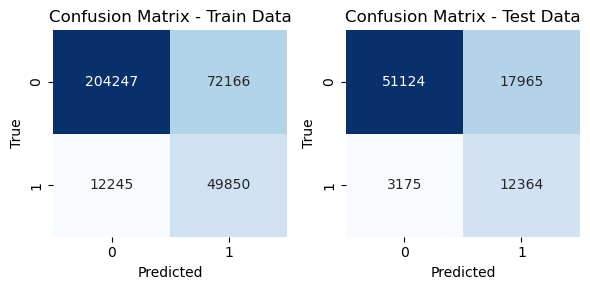

Rapport de classification - Données d'entraînement :
              precision    recall  f1-score   support

         0.0       0.94      0.74      0.83    276413
         1.0       0.41      0.80      0.54     62095

    accuracy                           0.75    338508
   macro avg       0.68      0.77      0.69    338508
weighted avg       0.85      0.75      0.78    338508




Rapport de classification - Données de test :
              precision    recall  f1-score   support

         0.0       0.94      0.74      0.83     69089
         1.0       0.41      0.80      0.54     15539

    accuracy                           0.75     84628
   macro avg       0.67      0.77      0.68     84628
weighted avg       0.84      0.75      0.78     84628



In [98]:
print_rapports(y_train, loaded_predictions_train, y_test, loaded_predictions_test)

### **7. Feature Importance with Random Forests**

In [108]:
features = X_train.columns
importances = mod_RF_simple.feature_importances_
FIM = pd.DataFrame({'Features': features, 'Importance': importances})
FIM = FIM.sort_values(by='Importance', ascending=False)
print("Nb de features total : ",len(FIM))
print("Nb de features avec importance > 0.01 : ",len(FIM[FIM['Importance']>0.01]))
FIM.head(20)


Nb de feature total :  181
Nb de feature avec importance > 0.01 :  22


Features  Importance
23     col_4.0    0.086302
133  secu1_2.0    0.085436
14       agg_2    0.074484
67    catv_1.0    0.072341
25      catr_3    0.057123
69    catv_3.0    0.051817
0       nb_veh    0.042729
26      catr_4    0.037115
28    circ_2.0    0.035847
32     nbv_2.0    0.034208
135  secu1_4.0    0.033620
91    obsm_2.0    0.030903
90    obsm_1.0    0.027417
97    choc_2.0    0.026906
68    catv_2.0    0.025145
129     catu_3    0.023500
127  place_3.0    0.017252
22     col_3.0    0.016721
21     col_2.0    0.012764
60    situ_1.0    0.012744

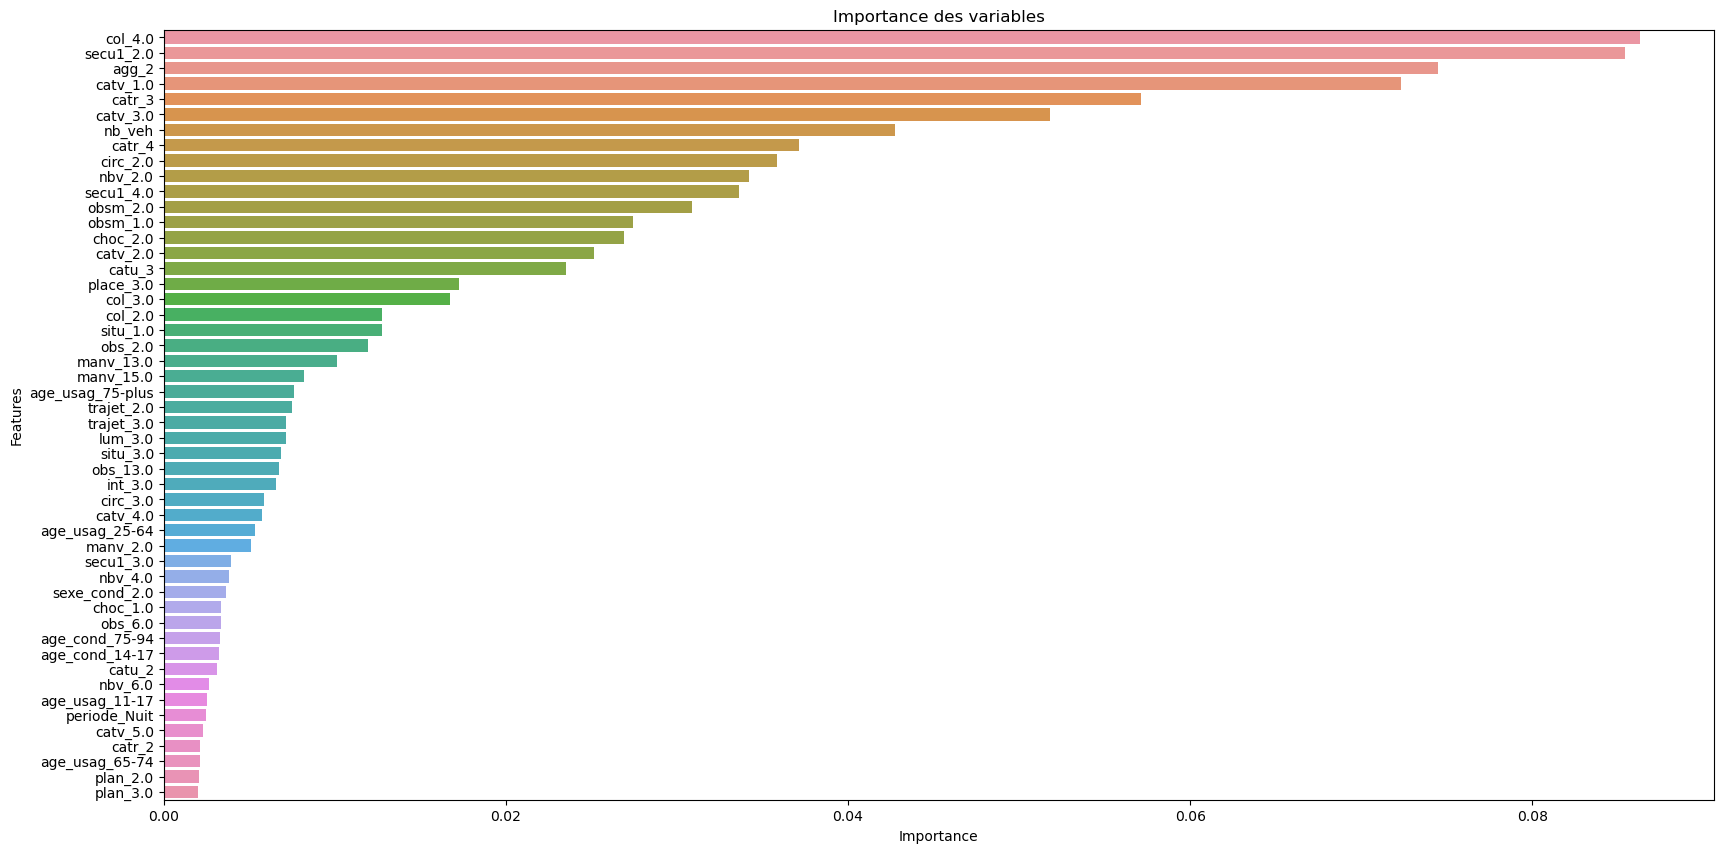

In [115]:
plt.figure(figsize=(20, 10))
plt.title("Importance des variables")
#top_bottom = FIM.head(22).append(FIM.tail(45))
top_bottom = FIM.head(50)
sns.barplot(x="Importance", y="Features", data=top_bottom)
plt.show()

In [ ]:
top_features = FIM['Features'].iloc[:35]

# nouveaux dataset d'entraînement et de test avec features selectionnées
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

In [ ]:
# Choix des hyperparamètres qui maximisent MCC,AUC,F1
param_check = results_df['params'][144]

mod_RF_simple = RF_bin_simple(X_train_selected, X_test_selected, y_train, y_test, param_check)
#mod_RF_simple = RF_bin_simple(X_train, X_test, y_train, y_test, param_check)

# Prédiction sur les données d'entraînement
y_train_pred = mod_RF_simple.predict(X_train_selected)

# Prédiction sur les données de test
y_test_pred = mod_RF_simple.predict(X_test_selected)
print_rapports(y_train, y_train_pred, y_test, y_test_pred)

### **8. Optimisation des resultat de prediction**

#### **8.1 ROC/AUC**



Résultats pour le point le plus proche du coin :
Coordonnées du point le plus proche : (0.24, 0.77)
Seuil de probabilité : 0.5181
Precision: 0.42
Recall: 0.77
F1-Score: 0.55
AUC-ROC : 0.84


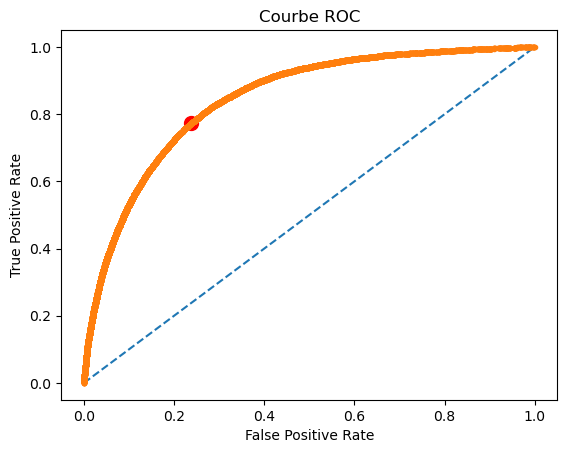

In [145]:
ns_probs = [0 for i in range(len(y_test))]
#y_prob = model.predict_proba(X_test)[:, 1]
y_prob = loaded_modele_RF.predict_proba(X_test)[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
RF_roc = roc_auc_score(y_test, y_prob)

#print('No Skill: ROC_AUC=%.3f' % (ns_auc))
#print("RF: ROC_AUC : {:.4f}".format(RF_roc))

# Calcul de la courbe ROC
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_prob)
ns_fpr, ns_tpr, ns_thresholds = roc_curve(y_test, ns_probs)

# Affichage de la courbe ROC
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')

# Calculer la courbe ROC
# fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# auc_roc = roc_auc_score(y_test, y_prob)

# le point le plus proche du coin supérieur gauche
closest_idx = np.argmin(np.sqrt((rf_fpr - 0)**2 + (rf_tpr - 1)**2))
closest_point = (rf_fpr[closest_idx], rf_tpr[closest_idx])
closest_threshold = rf_thresholds[closest_idx]

# valeurs de probabilité pour le point le plus proche du coin supérieur gauche
closest_prob = y_prob[np.argmax(np.logical_and(rf_fpr == closest_point[0], rf_tpr == closest_point[1]))]

# Appliquer le seuil de probabilité aux prédictions 
closest_pred = (y_prob >= closest_threshold).astype(int)

# Calculer les métriques de performance pour le point optimal
closest_precision = precision_score(y_test, closest_pred)
closest_recall = recall_score(y_test, closest_pred)
closest_f1 = f1_score(y_test, closest_pred)

# Tracer la courbe ROC 
plt.scatter(closest_point[0], closest_point[1], color='red', label='Point le plus proche',s=100, marker='o')

# Afficher les résultats 
print("Résultats pour le point le plus proche du coin :")
print('Coordonnées du point le plus proche : ({:.2f}, {:.2f})'.format(closest_point[0], closest_point[1]))
print("Seuil de probabilité : {:.4f}".format(closest_threshold))
print("Precision: {:.2f}".format(closest_precision))
print("Recall: {:.2f}".format(closest_recall))
print("F1-Score: {:.2f}".format(closest_f1))
print("AUC-ROC : {:.2f}".format(RF_roc))

plt.show()


Résultats pour le point qui maximise le rappel 
Seuil de probabilité : 0.4040
Precision: 0.3370
Recall: 0.9004
F1-Score: 0.4904
AUC-ROC : 0.84


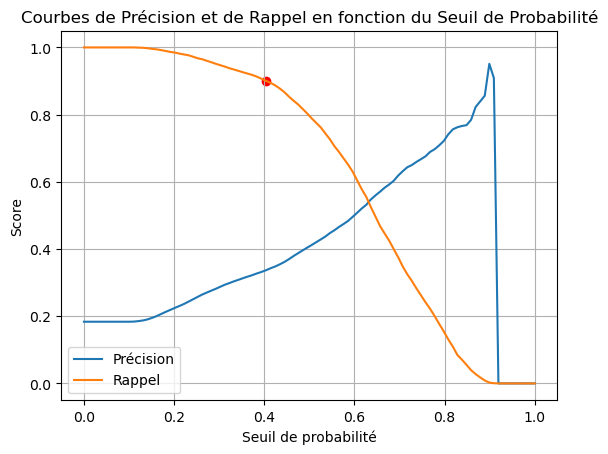

In [148]:

#y_prob = model.predict_proba(X_test)[:, 1]
y_prob = loaded_modele_RF.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_roc = roc_auc_score(y_test, y_prob)

thresholds_dense = np.linspace(0, 1, 100)


recall_threshold = 0.90  # Rappel souhaité
best_threshold = None
best_precision = 0.0
best_recall = 0.0

precision_values = []
recall_values = []

for threshold in thresholds_dense:
    y_pred = (y_prob >= threshold).astype(int)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0 )
    precision_values.append(precision)
    recall_values.append(recall)
    
    if recall >= recall_threshold:
        if precision > best_precision or (precision == best_precision and recall > best_recall):
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

# le meilleur seuil de probabilité 
y_pred_best = (y_prob >= best_threshold).astype(int)

# Calculer les métriques  avec le meilleur seuil
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)


# Afficher les résultats 
print("Résultats pour le point qui maximise le rappel ")
print("Seuil de probabilité : {:.4f}".format(best_threshold))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-Score: {:.4f}".format(f1))
print("AUC-ROC : {:.2f}".format(auc_roc))

# Tracer la courbe de précision et de rappel en fonction du seuil de probabilité
plt.figure()
plt.plot(thresholds_dense, precision_values, label='Précision')
plt.plot(thresholds_dense, recall_values, label='Rappel')
plt.xlabel('Seuil de probabilité')
plt.ylabel('Score')
plt.title('Courbes de Précision et de Rappel en fonction du Seuil de Probabilité')
plt.legend()

# Ajouter le point avec le rappel souhaité
plt.scatter(best_threshold, recall_threshold, color='red', marker='o', label='Rappel Souhaité')

plt.grid(True)
plt.show()


#### **8.2 Courbe Fscore**


In [38]:
##### #Entrainer le modele

#results_df['params'] = results_df['params'].apply(ast.literal_eval)

param_check = results_df['params'][144]

#Entrainer le modele avec les hyperparametres qui maximisent MCC,AUC,F1

mod_RF_simple = RF_bin_simple(X_train, X_test, y_train, y_test, param_check)
mod_RF_simple.fit(X_train, y_train)


### Charger le model depuis le fichier pkl

# Charger le dictionnaire depuis le fichier pkl
with open('Save_RandomForest/bin/trainModel_RF_bin_200combin_144.pkl', 'rb') as saved_data_file:
    loaded_data = pickle.load(saved_data_file)

# Accéder aux éléments du dictionnaire
loaded_modele_RF = loaded_data['modele_RF']
loaded_predictions_train = loaded_data['predictions_train']
loaded_predictions_test = loaded_data['predictions_test']

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_leaf=2, n_estimators=300, n_jobs=-1,
                       random_state=42)

##### **8.2.1. Affichage des courbes**

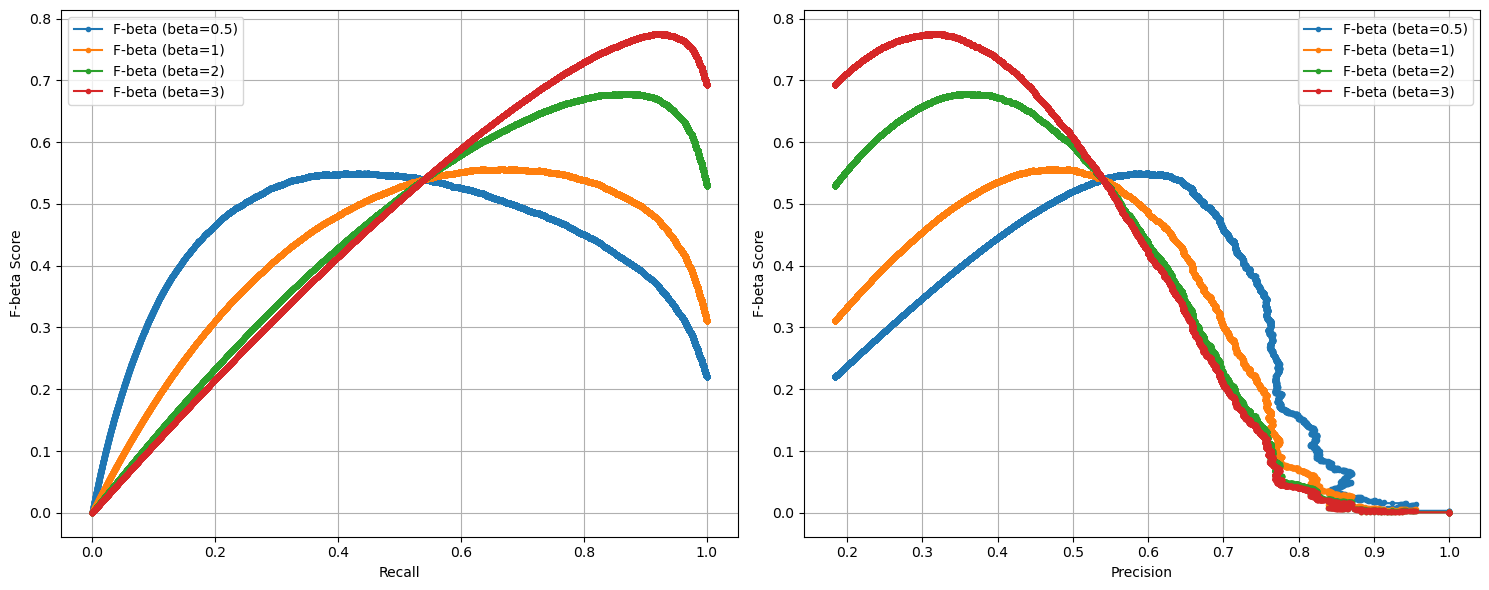

In [118]:

y_probs = loaded_modele_RF.predict_proba(X_test)[:, 1]
#y_probs = mod_RF_simple.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)


beta_values = [0.5, 1, 2, 3]


plt.figure(figsize=(15, 6))

# Courbes F-beta en fonction de Recall
plt.subplot(1, 2, 1)
for beta in beta_values:
    f_beta_scores = (1 + beta ** 2) * (precision * recall) / ((beta ** 2 * precision) + recall)
    f_beta_auc = auc(recall, f_beta_scores)
     #plt.plot(recall, f_beta_scores, marker='.', label=f'F-beta (beta={beta}) (AUC = {f_beta_auc:.2f})')
    plt.plot(recall, f_beta_scores, marker='.', label=f'F-beta (beta={beta})')

plt.xlabel('Recall')
plt.ylabel('F-beta Score')
#plt.title('F-beta Score Curves for Different Beta Values (Recall)')
plt.legend()
plt.grid(True)

# Courbes F-beta en fonction de Precision
plt.subplot(1, 2, 2)
for beta in beta_values:
    f_beta_scores = (1 + beta ** 2) * (precision * recall) / ((beta ** 2 * precision) + recall)
    f_beta_auc = auc(recall, f_beta_scores)
    #plt.plot(precision, f_beta_scores, marker='.', label=f'F-beta (beta={beta}) (AUC = {f_beta_auc:.2f})')
    plt.plot(precision, f_beta_scores, marker='.', label=f'F-beta (beta={beta})')

plt.xlabel('Precision')
plt.ylabel('F-beta Score')
#plt.title('F-beta Score Curves for Different Beta Values (Precision)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


##### **8.2.2. Optimisation du score**

In [122]:
# Obtenir les probabilités de prédiction pour la classe positive
#y_probs = mod_RF_simple.predict_proba(X_test)[:, 1]
y_probs = loaded_modele_RF.predict_proba(X_test)[:, 1]


precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Valeurs de beta
beta_values = [0.5, 1, 2, 3, 4]

desired_recall = 0.99

precision_values = []
f_beta_scores_values = []
recall_values = []
best_thresholds = []

num_thresholds = 100  
thresholds_to_test = np.linspace(0, 1, num_thresholds)

for beta in beta_values:
    f_beta_scores = (1 + beta ** 2) * (precision * recall) / ((beta ** 2 * precision) + recall)
    
    # Trouver  seuil qui maximise le score F-beta 
    best_threshold_index = np.argmax(f_beta_scores)
    best_threshold = thresholds[best_threshold_index]
    
    # Calculer la précision, le F-score et le rappel 
    best_precision = precision[best_threshold_index]
    best_f_beta_score = f_beta_scores[best_threshold_index]
    best_recall = recall[best_threshold_index]
    
    # Stocker les résultats
    precision_values.append(best_precision)
    f_beta_scores_values.append(best_f_beta_score)
    recall_values.append(best_recall)
    best_thresholds.append(best_threshold)

# Afficher les résultats
for beta, precision_value, f_beta_score_value, recall_value, threshold_value in zip(
    beta_values, precision_values, f_beta_scores_values, recall_values, best_thresholds
):
    print(f"Beta = {beta}, Précision = {precision_value:.4f}, F{beta}-score = {f_beta_score_value:.4f}, Rappel = {recall_value:.4f}")
    print(f"Seuil de probabilité optimal : {threshold_value:.4f}")
    print()

# Choisir la meilleure valeur de beta en fonction du F-score
best_beta_index = np.argmax(f_beta_scores_values)
best_beta = beta_values[best_beta_index]
best_precision = precision_values[best_beta_index]
best_recall = recall_values[best_beta_index]
best_threshold = best_thresholds[best_beta_index]

# Afficher les résultats pour la meilleure valeur de beta
print(f"Meilleure valeur de beta : {best_beta}")
print(f"Précision : {best_precision:.4f}")
print(f"F-score : {f_beta_scores_values[best_beta_index]:.4f}")
print(f"Rappel : {best_recall:.4f}")
print(f"Seuil de probabilité optimal : {best_threshold:.4f}")


# Tester manuellement le seuil optimal
#best_threshold = 0.6830

# Utiliser le seuil optimal pour prédictions sur test
y_pred = (y_probs >= best_threshold).astype(int)

#  matrice de confusion et le rapport de classification
confusion = confusion_matrix(y_test, y_pred)
print("Matrice de confusion:")
print(confusion)

report = classification_report(y_test, y_pred)
print("Rapport de classification:")
print(report)


Beta = 0.5, Précision = 0.6000, F0.5-score = 0.5495, Rappel = 0.4111
Seuil de probabilité optimal : 0.6830

Beta = 1, Précision = 0.4781, F1-score = 0.5562, Rappel = 0.6648
Seuil de probabilité optimal : 0.5789

Beta = 2, Précision = 0.3552, F2-score = 0.6778, Rappel = 0.8770
Seuil de probabilité optimal : 0.4355

Beta = 3, Précision = 0.3200, F3-score = 0.7751, Rappel = 0.9205
Seuil de probabilité optimal : 0.3680

Beta = 4, Précision = 0.2721, F4-score = 0.8353, Rappel = 0.9595
Seuil de probabilité optimal : 0.2752

Meilleure valeur de beta : 4
Précision : 0.2721
F-score : 0.8353
Rappel : 0.9595
Seuil de probabilité optimal : 0.2752
Matrice de confusion:
[[29205 39884]
 [  630 14909]]
Rapport de classification:
              precision    recall  f1-score   support

         0.0       0.98      0.42      0.59     69089
         1.0       0.27      0.96      0.42     15539

    accuracy                           0.52     84628
   macro avg       0.63      0.69      0.51     84628
weigh